In [1]:
INSTANCE_ID = open("INSTANCE_ID").read()

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType, CustomUrlParam
from sentinelhub.common import BBox, CRS # Different than in examples
from sentinelhub import CustomUrlParam

/Users/joosko/work/ijs/ml/SentinelHub/venv/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))


In [5]:
import datetime
end_time = datetime.datetime.now().strftime('%Y-%m-%d')
start_time = '2017-12-01'

In [6]:
def plot_image(data, factor=1./255, cmap=None):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting 
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    rgb = data.astype(np.float32)
    if len(rgb.shape) == 3 and rgb.shape[2] == 3:
        rgb = rgb[..., [2, 1, 0]]
    plt.imshow(rgb * factor, cmap=cmap)
    

def plot_timeseries(data, factor=1./255):
    """
    Utility function for ploting timeseries type data.
    """
    return plot_image(np.array([data]))

reverse = 1
# CAUTION: Numpy saves colors in reversed order
if reverse:
    grayscale_convert_parameters = tuple(reversed((0.299, 0.587, 0.114)))
else:
    grayscale_convert_parameters = (0.299, 0.587, 0.114)
    
def to_grayscale(img, grayscale_factor = grayscale_convert_parameters):
    gray = np.dot(img[...,:3], grayscale_factor)
    if len(gray.shape) <= 1:
        gray = gray.reshape(*gray.shape, 1).T
    return gray

def plot_grayscale(img, grayscale_factor = grayscale_convert_parameters):
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    plt.imshow(to_grayscale(img, grayscale_factor), cmap="gray")

In [7]:
fmf_box = [46.042,14.487, 46.043,14.488]
fmf_box = BBox(bbox=fmf_box, crs=CRS.WGS84)

In [8]:
cloud_detect_url = 'https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/cby_cloud_detection/script.js'
trim_cloud_detect_url = 'https://raw.githubusercontent.com/jO-Osko/cloudDetector/master/cd.js'
                
# Get data from sentinel hub
data_request_orig = WmsRequest(layer='TRUE_COLOR', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          custom_url_params={CustomUrlParam.SHOWLOGO: False}
                              )
# same, just add parameters for filter
data_request_cloud = WmsRequest(layer='TRUE_COLOR', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          custom_url_params={CustomUrlParam.SHOWLOGO: False, 
                                             CustomUrlParam.EVALSCRIPTURL: cloud_detect_url}
                              )

data_request_trim = WmsRequest(layer='TRUE_COLOR', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          custom_url_params={CustomUrlParam.SHOWLOGO: False, 
                                             CustomUrlParam.EVALSCRIPTURL: trim_cloud_detect_url}
                             )

# Caution
# MOISTURE_INDEX and FALSE_COLOR are automatically set to only acquire data that has less than 20% of cloud coverage
# CAUTION AGAIN: this applies to coverage of whole satelite tile, not for specific gps bounding box, so 
# bounding box may still have full cloud coverage (or zero)
data_request_orig_moist = WmsRequest(layer='MOISTURE_INDEX', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          #image_format=MimeType.TIFF_d32f,
                          custom_url_params={CustomUrlParam.SHOWLOGO: False}
                              )

data_request_orig_vegetation = WmsRequest(layer='FALSE_COLOR', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          #image_format=MimeType.TIFF_d32f,
                          custom_url_params={CustomUrlParam.SHOWLOGO: False}
                              )

data_request_orig_moist_gray = WmsRequest(layer='MOISTURE-GRAYSCALE2', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          #image_format=MimeType.TIFF_d32f,
                          custom_url_params={CustomUrlParam.SHOWLOGO: False}
                              )
# MOISTURE-GRAYSCALE2 script from configurator (Product: Moisture Index - Grayscale visualization):
"""
let minValue = -0.4;
let maxValue = 0.8;

let viz = new HighlightCompressVisualizerSingle(minValue, maxValue);

function evaluatePixel(samples) {
    let val = index(samples[0].B8A, samples[0].B11);
    return viz.process(val);
}

function setup(ds) {
    setInputComponents([ds.B8A, ds.B11]);
    setOutputComponentCount(1);
}
"""


data_imgs_orig = data_request_orig.save_data()
data_imgs_cloud = data_request_cloud.save_data()
data_imgs_trim = data_request_trim.save_data()
data_imgs_veg = data_request_orig_vegetation.save_data()
data_imgs_moist = data_request_orig_moist.save_data()
data_imgs_moist_gray = data_request_orig_moist_gray.save_data()

In [9]:
# Convert to np array
# data is of the form [index, x_coor, y_coor]
# if multiple bands are used : [index, x_coor, y_coor, band_index]
data_imgs_orig = np.array(data_request_orig.get_data())
data_imgs_cloud = np.array(data_request_cloud.get_data())
data_imgs_trim = np.array(data_request_trim.get_data())
data_imgs_veg = np.array(data_request_orig_vegetation.get_data())
data_imgs_moist = np.array(data_request_orig_moist.get_data())
data_imgs_moist_gray = np.array(data_request_orig_moist_gray.get_data())

/Users/joosko/work/ijs/ml/SentinelHub/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


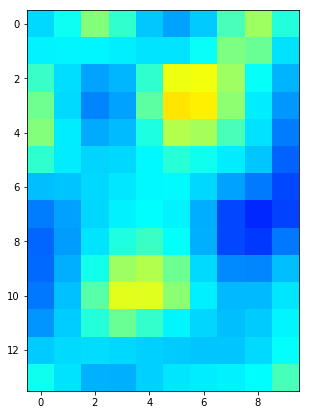

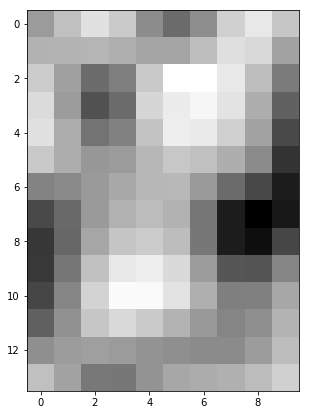

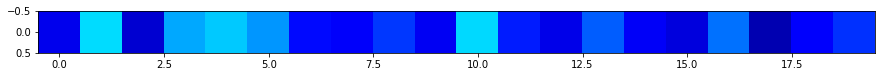

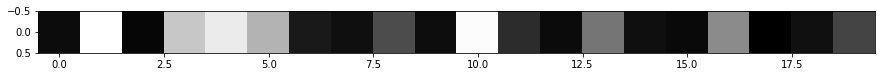

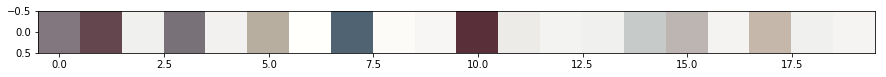

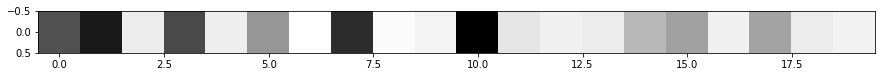

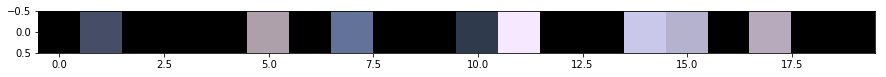

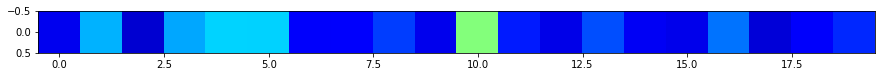

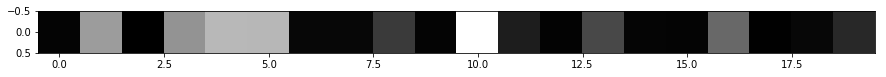

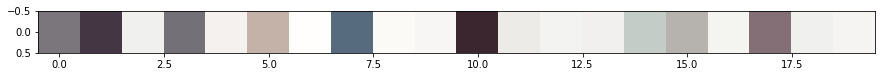

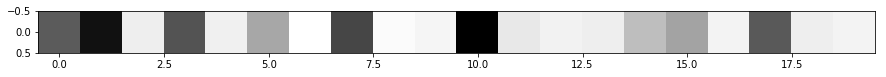

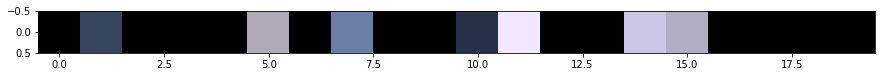

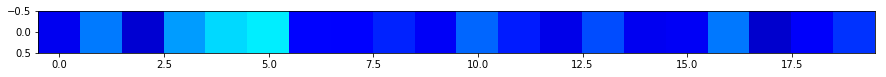

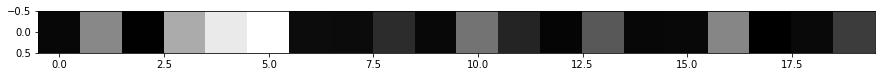

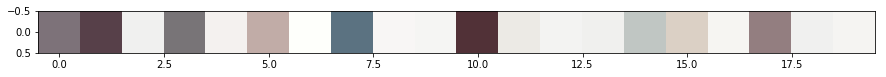

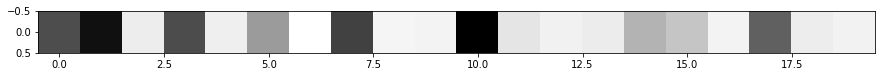

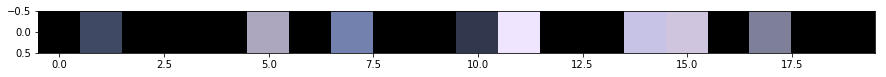

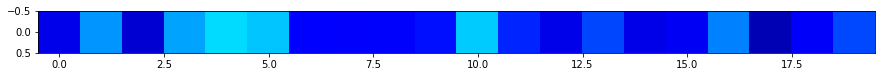

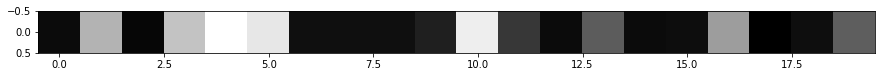

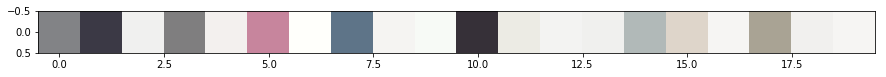

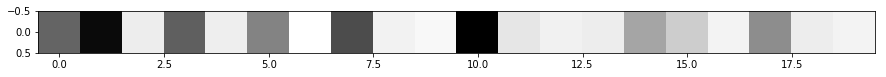

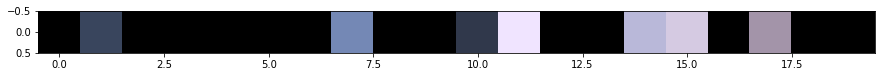

In [10]:
plot_image(data_imgs_moist[10])
plot_grayscale(data_imgs_moist[10])

for x in range(0,14,4):
    for y in range(0,10,2):
        # Sample timeseries (in color and grayscale) for moisture and vegetation
        time_s_moist = data_imgs_moist[:,x, y]
        plot_timeseries(time_s_moist)
        plot_grayscale(time_s_moist)
        time_s_veg = data_imgs_veg[:,x, y]
        plot_timeseries(time_s_veg)
        plot_grayscale(time_s_veg)
        # Full black pixels are detected by cloud detection (not totally reliable)
        plot_timeseries(data_imgs_trim[:,x,y])
        break

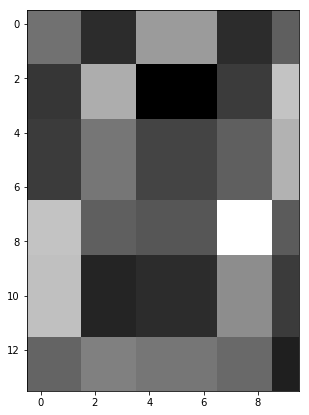

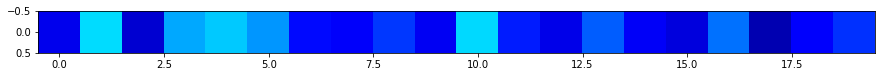

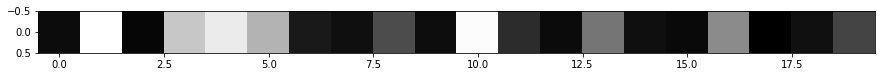

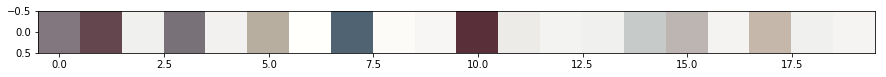

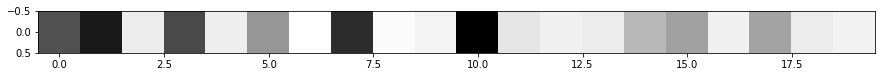

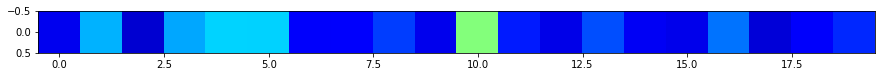

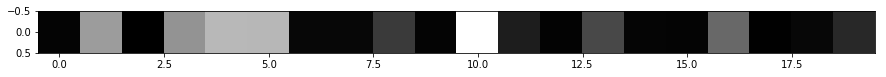

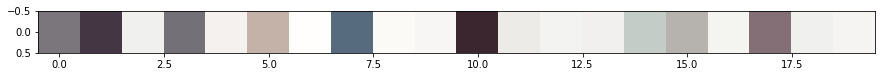

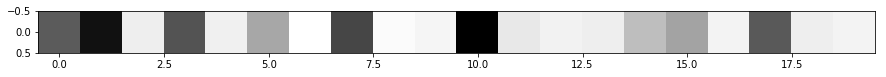

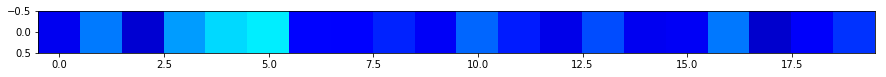

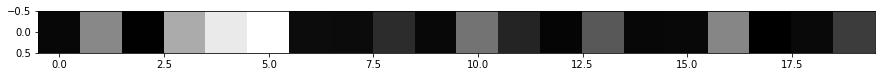

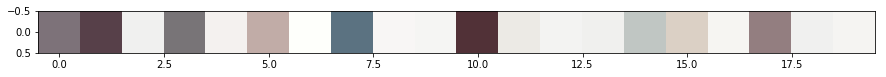

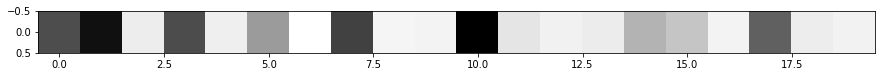

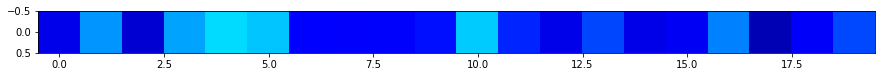

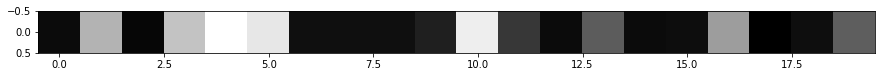

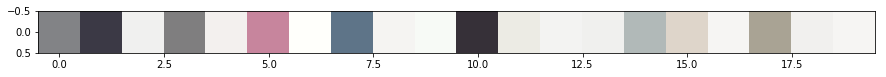

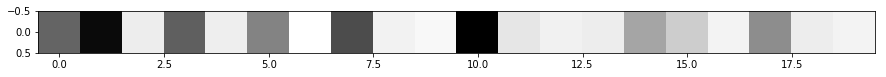

In [11]:
# Not setting cmap will plot it in color
plot_image(data_imgs_moist_gray[10], cmap="gray")
# Plot grayscale timeseries from configurator index

for x in range(0,14,4):
    for y in range(0,10,2):
        time_s_moist = data_imgs_moist[:,x, y]
        plot_timeseries(time_s_moist)
        plot_grayscale(time_s_moist)
        time_s_veg = data_imgs_veg[:,x, y]
        plot_timeseries(time_s_veg)
        plot_grayscale(time_s_veg)
        break